# Component z-density of CaCO3 Interfaces with Water

Author: Alec Glisman  
Date: 2024-02-02

## Imports

In [1]:
%matplotlib widget


In [2]:
# standard library
from dataclasses import dataclass
import os
from pathlib import Path

# third-party
import colorcet as cc
import cmasher as cmr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import sys
from tqdm.auto import tqdm

# local
dir_proj_base = Path().cwd().parents[2]
sys.path.insert(0, f"{dir_proj_base}/src")

from render.util import set_style  # noqa: E402


In [3]:
set_style()


## Load Data

### User Inputs

In [4]:
# parameters
verbose = True
data_path = Path().cwd().parent / "data" / "START_1000-STOP_500000-STEP_25"
fig_args = {"dpi": 600, "bbox_inches": "tight"}
fig_ext = "png"
dir_output = Path().cwd() / "../output/axial_density"

zmin = 0.1 # nm
zmax = 1.2 # nm

labels = [
    r"Neat",
    r"64 CaCl$_2$",
    r"64 CaCO$_3$",
    r"16 AA",
    r"16 An",
    r"16 VAl",
    r"16 VAc",
]


In [5]:
dir_fig = dir_output / "figures"
dir_dat = dir_output / "data"

dir_fig.mkdir(exist_ok=True, parents=True)
dir_dat.mkdir(exist_ok=True, parents=True)


### Classes and Functions

In [6]:
@dataclass(frozen=False, order=True)
class Sim:
    """
    Dataclass for a single simulation
    """
    name: str
    sampling: str
    label: str
    z_all: list[np.ndarray]
    z_numden_osol: list[np.ndarray]
    z_numden_ca: list[np.ndarray] = None
    z_numden_cl: list[np.ndarray] = None
    z_numden_pe: list[np.ndarray] = None
    z_surface_pos: float = 0.0


In [7]:
def load_simulations(data_path: Path, labels: list[str]) -> list[Sim]:
    """
    Load all simulations from a directory

    Parameters
    ----------
    data_path : Path
        Path to the directory containing the simulations
    labels : list[str]
        List of labels for each simulation
    
    Returns
    -------
    list[Sim]
        List of Sim objects
    
    Raises
    ------
    FileNotFoundError
        If the data_path does not exist
    """
    # verify path exists
    if not data_path.exists():
        raise FileNotFoundError(f"{data_path} does not exist")

    # iterate over all files in the directory and load the data
    sims = []
    simulations = [x for x in data_path.iterdir() if x.is_dir()]

    # FIXME: remove this line
    simulations = simulations[:3]

    if verbose:
        print(f"Found {len(simulations)} simulations")

    # iterate over all simulation systems
    for i, simulation in tqdm(enumerate(simulations), desc="Simulations", dynamic_ncols=True):
        if verbose:
            print(f" - Processing {simulation.name}")

        # iterate over all sampling methods
        sampling_methods = [x for x in simulation.iterdir() if x.is_dir()]
        for sampling_method in sampling_methods:
            if verbose:
                print(f"   - Sampling: {sampling_method.name}")

            sim = Sim(
                name=simulation.name,
                sampling=sampling_method.name,
                label=labels[i],
                z_all=np.load(
                    sampling_method
                    / f"mdanalysis_potential/data/linear_density_z_all.npz"
                ),
                z_numden_osol=np.load(
                    sampling_method
                    / f"mdanalysis_lineardensity/data/lineardensity_z_resname_SOL_and_name_OW_atoms.npz"
                ),
                z_numden_ca=np.load(
                    sampling_method
                    / f"mdanalysis_lineardensity/data/lineardensity_z_resname_CA_and_name_CA_atoms.npz"
                ),
                z_numden_cl=(
                    np.load(
                        sampling_method
                        / f"mdanalysis_lineardensity/data/lineardensity_z_resname_CL_and_name_CL_atoms.npz"
                    )
                    if (simulation.name == "64CaCl2")
                    else None
                ),
                z_numden_pe=np.load(
                    sampling_method
                    / f"mdanalysis_lineardensity/data/lineardensity_z_resname_LAI_ACI_RAI_AI1_LAN_ACN_RAN_AN1_LAC_ACE_RAC_AC1_LAL_ALC_RAL_AL1_fragments.npz"
                ) if ("-16" in simulation.name) else None,
            )
            sims.append(sim)

    return sims

### Script

In [8]:
sims = load_simulations(data_path, labels)


Found 3 simulations


Simulations: 0it [00:00, ?it/s]

 - Processing 4.1.0-calcite-104surface-9nm_surface-10nm_vertical-0chain-PAcr-0mer-0Crb-0Ca-0Na-0Cl-300K-1bar-NVT
   - Sampling: md
 - Processing 4.2.0-calcite-104surface-9nm_surface-10nm_vertical-0chain-PAcr-0mer-0Crb-64Ca-0Na-128Cl-300K-1bar-NVT
   - Sampling: md
 - Processing 4.3.0-calcite-104surface-9nm_surface-10nm_vertical-0chain-PAcr-0mer-64Crb-64Ca-0Na-0Cl-300K-1bar-NVT
   - Sampling: md


In [9]:
def save_fig(
    data: dict[str, np.ndarray],
    fig: plt.Figure, 
    figname: str,
    dir_dat: Path,
    dir_fig: Path, 
    ext: str = "png",
    fig_args: dict[str, any] = {"dpi": 600, "bbox_inches": "tight"}
) -> None:
    """
    Save a figure to a directory

    Parameters
    ----------
    data : dict[str, np.ndarray]
        Dictionary of data to save
    fig : plt.Figure
        Figure to save
    figname : str
        Name of the figure
    dir_dat : Path
        Directory to save the data
    dir_fig : Path
        Directory to save the figure
    ext : str
        Extension of the figure
    fig_args : dict[str, any]
        Arguments to pass to fig.savefig()
    """
    # pad data with NaNs
    max_length = max([len(value) for value in data.values()])
    for key, value in data.items():
        data[key] = np.pad(value, (0, max_length - len(value)), mode="constant", constant_values=np.nan)

    # save the figure
    df = pd.DataFrame(data)
    df.to_csv(dir_dat / f"{figname}.csv", index=False)
    fig.savefig(dir_fig / f"{figname}.{fig_ext}", **fig_args)


## Find CaCO3 surface z-coordinate

### Find surface z-coordinate

Surface position:   0%|          | 0/3 [00:00<?, ?it/s]

Simulation: md - Neat
 - Surface position [A]: 24.18
Simulation: md - 64 CaCl$_2$
 - Surface position [A]: 24.13
Simulation: md - 64 CaCO$_3$
 - Surface position [A]: 24.04


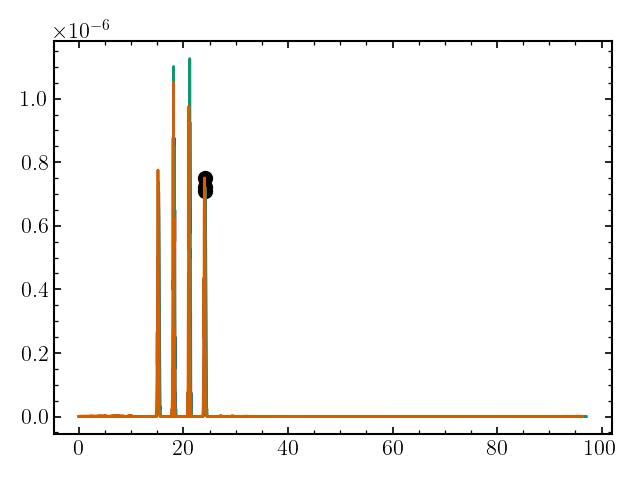

In [32]:
# find surface z-coordinate as last major peak in the number density profile
fig, ax = plt.subplots()

for sim in tqdm(sims, desc="Surface position", dynamic_ncols=True):
    z_ca = sim.z_numden_cal["number_density"]
    z_pos = sim.z_numden_cal["hist_bin_centers"]

    ax.plot(z_pos, z_ca, label=sim.label)

    maxima, _ = find_peaks(z_ca, distance=10, prominence=0.001)
    sim.z_surface_pos = z_pos[maxima[-1]]
    ax.scatter(sim.z_surface_pos, z_ca[maxima[-1]], color="black")

    if verbose:
        print(f"Simulation: {sim.sampling} - {sim.label}")
        print(f" - Surface position [A]: {sim.z_surface_pos:.2f}")

# save data
tags, z_pos = [], []
for sim in sims:
    tags.append(sim.name + "_" + sim.sampling)
    z_pos.append(sim.z_surface_pos)
df = pd.DataFrame({"tag": tags, "z_surface_pos_ang": z_pos})
df.to_csv(dir_dat / "z_surface_pos.csv", index=False)


In [33]:
# find surface z-coordinate as last major peak in the number density profile
for sim in tqdm(sims, desc="Surface position", dynamic_ncols=True):
    z_ca = sim.z_numden_cal["number_density"]
    z_pos = sim.z_numden_cal["hist_bin_centers"]

    maxima, _ = find_peaks(z_ca, distance=10)
    sim.z_surface_pos = z_pos[maxima[-1]]

    if verbose:
        print(f"Simulation: {sim.sampling} - {sim.label}")
        print(f" - Surface position [A]: {sim.z_surface_pos:.2f}")

# save data
tags, z_pos = [], []
for sim in sims:
    tags.append(sim.name + "_" + sim.sampling)
    z_pos.append(sim.z_surface_pos)
df = pd.DataFrame({"tag": tags, "z_surface_pos_ang": z_pos})
df.to_csv(dir_dat / "z_surface_pos.csv", index=False)


Surface position:   0%|          | 0/3 [00:00<?, ?it/s]

Simulation: md - Neat
 - Surface position [A]: 24.74
Simulation: md - 64 CaCl$_2$
 - Surface position [A]: 96.69
Simulation: md - 64 CaCO$_3$
 - Surface position [A]: 96.31


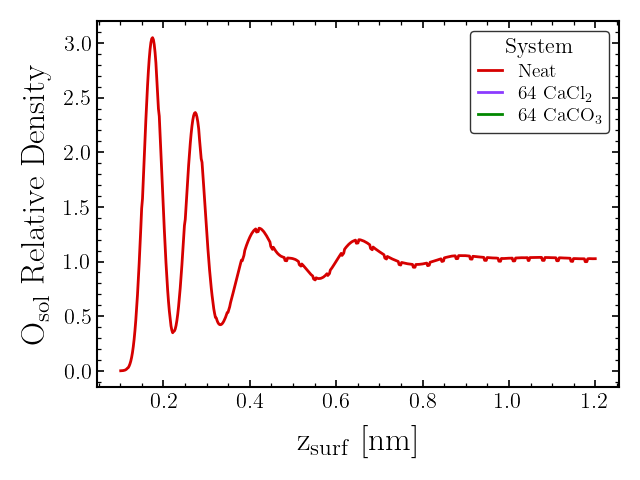

In [37]:
# plot the number density profile of water oxygen atoms
cmap = cc.glasbey
figname = "osol_density_z"
window = 20
fig, ax = plt.subplots()

data = {}
for i, sim in enumerate(sims):
    x = (sim.z_numden_osol["hist_bin_centers"] - sim.z_surface_pos) / 10.0
    y = sim.z_numden_osol["number_density"] / np.average(sim.z_numden_osol["number_density"][-10:])
    # moving average
    y = np.convolve(y, np.ones(window), "same") / window
    # remove data outside the range
    idx_drop = np.where((x < zmin) | (x > zmax))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)
    # save data
    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y

    ax.plot(x, y, label=sim.label, color=cmap[sims.index(sim)])

ax.set_xlabel(r"z$_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"O$_{\mathrm{sol}}$ Relative Density")
ax.legend(title="System")

save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()


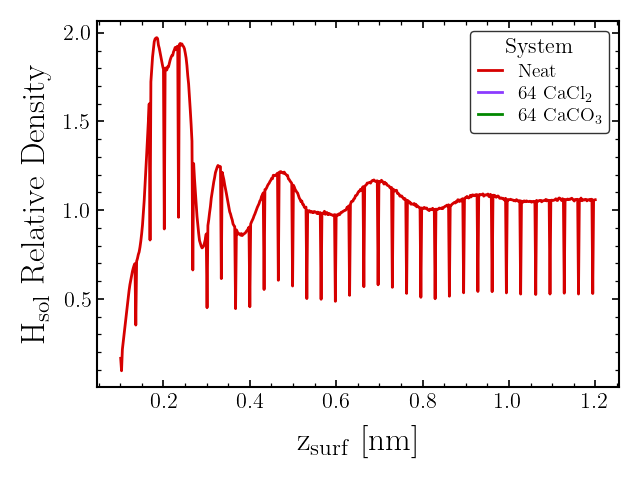

In [35]:
# plot the number density profile of water oxygen atoms
cmap = cc.glasbey
figname = "hsol_density_z"
fig, ax = plt.subplots()

data = {}
for i, sim in enumerate(sims):
    x = (sim.z_numden_hsol["hist_bin_centers"] - sim.z_surface_pos) / 10.0
    y = sim.z_numden_hsol["number_density"] / np.average(
        sim.z_numden_hsol["number_density"][-10:]
    )
    idx_drop = np.where((x < zmin) | (x > zmax))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)
    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y

    ax.plot(x, y, label=sim.label, color=cmap[sims.index(sim)])

ax.set_xlabel(r"z$_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"H$_{\mathrm{sol}}$ Relative Density")
ax.legend(title="System")

save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()

TypeError: 'NoneType' object is not subscriptable

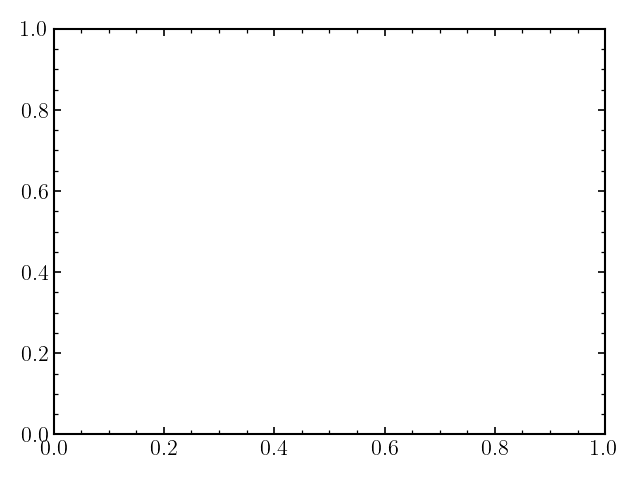

In [13]:
# plot the number density profile of water oxygen atoms
cmap = cc.glasbey
figname = "pe_density_z"
fig, ax = plt.subplots()

data = {}
for i, sim in enumerate(sims):
    # calcium ions
    print(f"Number of data points: {len(sim.z_numden_pe['hist_bin_centers'])}")
    x = (sim.z_numden_pe["hist_bin_centers"] - sim.z_surface_pos) / 10.0
    y = sim.z_numden_pe["number_density"] / np.average(
        sim.z_numden_pe["number_density"][-200:-120]
    )
    y = np.convolve(y, np.ones(3), "same") / 3
    idx_drop = np.where((x < zmin) | (x > zmax + 1))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)

    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y

    ax.plot(x, y, label=sim.label, color=cmap[sims.index(sim)])

ax.set_xlabel(r"z$_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"Monomer Relative Density")
ax.legend(title="System")

save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()


TypeError: 'NoneType' object is not subscriptable

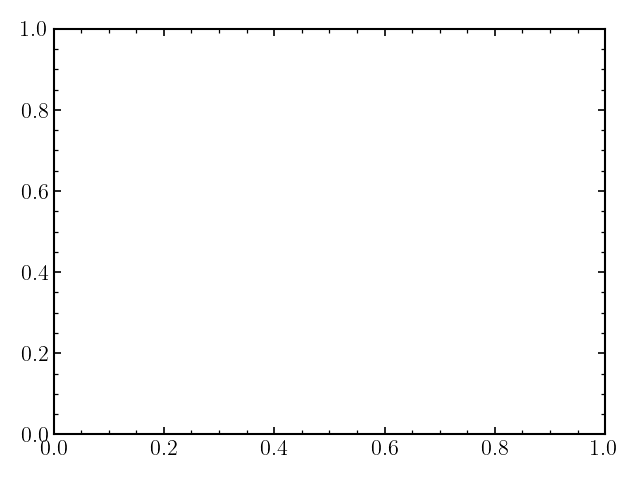

In [14]:
# plot the number density profile of water oxygen atoms
cmap = cc.glasbey
figname = "pe_density_z_fes"
fig, ax = plt.subplots()

data = {}
for i, sim in enumerate(sims):
    # calcium ions
    print(f"Number of data points: {len(sim.z_numden_pe['hist_bin_centers'])}")
    x = (sim.z_numden_pe["hist_bin_centers"] - sim.z_surface_pos) / 10.0
    y = sim.z_numden_pe["number_density"] / np.average(
        sim.z_numden_pe["number_density"][-200:-120]
    )
    y = np.convolve(y, np.ones(3), "same") / 3
    idx_drop = np.where((x < zmin) | (x > zmax + 1))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)
    y = -np.log(y)
    y = y - np.average(y[-20:])

    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y

    ax.plot(x, y, label=sim.label, color=cmap[sims.index(sim)], linewidth=2.5)

ax.set_xlabel(r"z$_{\mathrm{surf}}$ [nm]")
ax.set_xlim(0.3, 1.5)
ax.set_ylabel(r"$\Delta F$ [$k_BT$]")
ax.set_ylim(-1.2, 2.1)
ax.legend(title="System")

save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()

/tmp/ipykernel_2303015/244064816.py:10: RuntimeWarning: divide by zero encountered in divide
  y = sim.z_numden_cal["number_density"] / np.average(
/tmp/ipykernel_2303015/244064816.py:10: RuntimeWarning: invalid value encountered in divide
  y = sim.z_numden_cal["number_density"] / np.average(


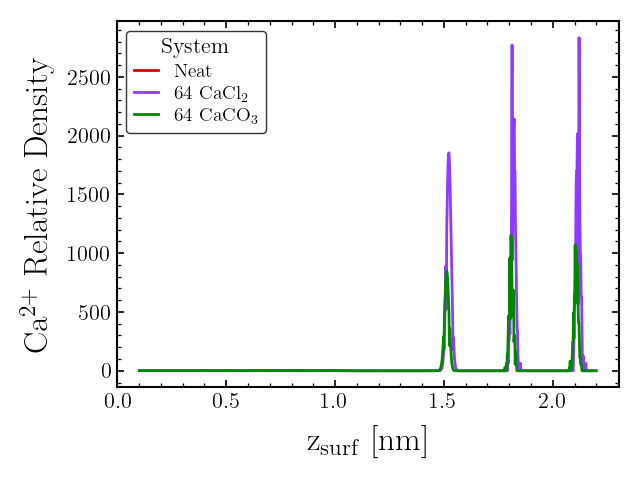

In [15]:
# plot the number density profile of water oxygen atoms
cmap = cc.glasbey
figname = "ca_density_z"
fig, ax = plt.subplots()

data = {}
for i, sim in enumerate(sims):
    # calcium ions
    x = (sim.z_numden_cal["hist_bin_centers"] - sim.z_surface_pos) / 10.0
    y = sim.z_numden_cal["number_density"] / np.average(
        sim.z_numden_cal["number_density"][-10:]
    )
    idx_drop = np.where((x < zmin) | (x > zmax + 1))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)
    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y

    ax.plot(x, y, label=sim.label, color=cmap[sims.index(sim)])

ax.set_xlabel(r"z$_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"Ca$^{2+}$ Relative Density")
ax.legend(title="System")

save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()

/tmp/ipykernel_2303015/2265698635.py:10: RuntimeWarning: divide by zero encountered in divide
  y = sim.z_numden_cal["number_density"] / np.average(
/tmp/ipykernel_2303015/2265698635.py:10: RuntimeWarning: invalid value encountered in divide
  y = sim.z_numden_cal["number_density"] / np.average(


TypeError: 'NoneType' object is not subscriptable

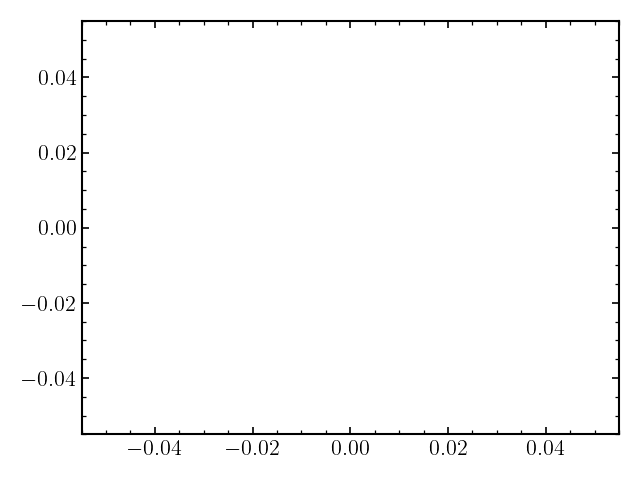

In [16]:
# plot the number density profile of water oxygen atoms
cmap = cc.glasbey
figname = "cacl_density_z"
fig, ax = plt.subplots()

data = {}
for i, sim in enumerate(sims):
    # calcium ions
    x = (sim.z_numden_cal["hist_bin_centers"] - sim.z_surface_pos) / 10.0
    y = sim.z_numden_cal["number_density"] / np.average(
        sim.z_numden_cal["number_density"][-10:]
    )
    idx_drop = np.where((x < zmin) | (x > zmax + 1))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)
    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y
    ax.plot(x, y, label="Ca$^{2+}$", color=cmap[sims.index(sim)], linestyle="-")
    
    # chloride ions
    x = (sim.z_numden_cl["hist_bin_centers"] - sim.z_surface_pos) / 10.0
    y = sim.z_numden_cl["number_density"] / np.average(
        sim.z_numden_cl["number_density"][-10:]
    )
    idx_drop = np.where((x < zmin) | (x > zmax + 1))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)
    data[f"line_{i}_x_cl"] = x
    data[f"line_{i}_y_cl"] = y
    ax.plot(x, y, label="Cl$^-$", color=cmap[sims.index(sim) + 1], linestyle="-")


ax.set_xlabel(r"z$_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"Relative Density")
ax.legend(title="Component", loc="best")

save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()

In [ ]:
# plot the number density profile of water oxygen atoms
cmap = cc.glasbey
figname = "all_chargedensity_z"
fig, ax = plt.subplots()

data = {}
for i, sim in enumerate(sims):
    x = (sim.z_numden_all["hist_bin_centers"] - sim.z_surface_pos) / 10.0
    y = sim.z_numden_all["charge_density"] 
    idx_drop = np.where((x < 0.17) | (x > zmax))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)
    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y

    ax.plot(x, y, label=sim.label, color=cmap[sims.index(sim)])

ax.set_xlabel(r"z$_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"Charge Density [$e$$\cdot$mol/cm$^3$]")
ax.legend(title="System", loc="lower right")

save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()

In [ ]:
# plot the number density profile of water oxygen atoms
cmap = cc.glasbey
figname = "notsol_chargedensity_z"
fig, ax = plt.subplots()

data = {}
for i, sim in enumerate(sims):
    x = (sim.z_numden_notsol["hist_bin_centers"] - sim.z_surface_pos) / 10.0
    y = sim.z_numden_notsol["charge_density"]
    idx_drop = np.where((x < 0.17) | (x > zmax))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)
    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y
    if sim.label == "64 CaCO$_3$":
        continue

    ax.plot(x, y, label=sim.label, color=cmap[sims.index(sim)])

ax.set_xlabel(r"z$_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"Charge Density [$e$$\cdot$mol/cm$^3$]")
ax.legend(title="System")

save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()